<a href="https://colab.research.google.com/github/faezesarlakifar/face-emotion-recognition/blob/main/transfer_learning_face_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import essential libraries**

In [ ]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch import optim
from torchvision import datasets, transforms
import torchvision
from torch.utils.data import DataLoader, SubsetRandomSampler, Dataset
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training
from PIL import Image, ImageDraw
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
import copy
import glob
import cv2
import seaborn as sns
import shutil

**Set hyper parameter and constants here**

In [ ]:
data_dir = './dataset_RGB/train/data-03'
batch_size = 16
epochs = 25
workers = 0
num_classes = 1
learning_rate = 0.001

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cpu


**MTCNN pre-trained model**

In [ ]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True, keep_all=False,
    device=device
)
help(MTCNN)

Help on class MTCNN in module facenet_pytorch.models.mtcnn:

class MTCNN(torch.nn.modules.module.Module)
 |  MTCNN(image_size=160, margin=0, min_face_size=20, thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True, select_largest=True, selection_method=None, keep_all=False, device=None)
 |  
 |  MTCNN face detection module.
 |  
 |  This class loads pretrained P-, R-, and O-nets and returns images cropped to include the face
 |  only, given raw input images of one of the following types:
 |      - PIL image or list of PIL images
 |      - numpy.ndarray (uint8) representing either a single image (3D) or a batch of images (4D).
 |  Cropped faces can optionally be saved to file
 |  also.
 |  
 |  Keyword Arguments:
 |      image_size {int} -- Output image size in pixels. The image will be square. (default: {160})
 |      margin {int} -- Margin to add to bounding box, in terms of pixels in the final image. 
 |          Note that the application of the margin differs slightly from the 

**Face Detection & Extraction**

In [ ]:
try:

	# creating a folder named data
	if not os.path.exists('detected_faeces-4'):
		os.makedirs('detected_faeces-4')

# if not created then raise error
except OSError:
	print ('Error: Creating directory of detected_faeces-4')

ctr = 0
for filename in os.listdir(data_dir):
        img = Image.open(os.path.join(data_dir,filename))
        boxes, probs, points = mtcnn.detect(img, landmarks=True)
        img_draw = img.copy()
        draw = ImageDraw.Draw(img_draw)
        imgplot = plt.imshow(img)
        plt.show()

        if type(boxes) != type(None):
            for i, (box, point) in enumerate(zip(boxes, points)):
                draw.rectangle(box.tolist(), width=5)
                for p in point:
                    draw.rectangle((p - 10).tolist() + (p + 10).tolist(), width=1)
            mtcnn.extract(img, boxes, save_path='detected_faeces-4/detected_face_{}.png'.format(ctr))
            ctr += 1

# Remove mtcnn to reduce GPU memory usage
del mtcnn

**prepare our custom dataset for use it with a pre-trained model**

In [ ]:
class CustomDataset(Dataset):
    def __init__(self):
        self.imgs_path = r'dataset_Labeled/'
        file_list = glob.glob(self.imgs_path + "*")
        print(file_list)
        self.data = []
        for class_path in file_list:
            class_name = class_path.split("\\")[-1]
            print("calss name: ", class_name)
            for img_path in glob.glob(class_path + "\*.jpg"):
                self.data.append([img_path, class_name])
        print(self.data)
        #self.class_map = {"Others" : 0, "Human_Face": 1 }
        self.class_map = { "Human_Face": 0 }
        self.img_dim = (128, 128)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        img = cv2.imread(img_path)
        img = cv2.resize(img, self.img_dim)
        class_id = self.class_map[class_name]
        img_tensor = torch.from_numpy(img)
        img_tensor = img_tensor.permute(2, 0, 1)
        class_id = torch.tensor([class_id])
        return img_tensor, class_id

In [ ]:
    dataset = CustomDataset()
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

['dataset_Labeled\\Human_Face']
calss name:  Human_Face
[['dataset_Labeled\\Human_Face\\num0.jpg', 'Human_Face'], ['dataset_Labeled\\Human_Face\\num1.jpg', 'Human_Face'], ['dataset_Labeled\\Human_Face\\num10.jpg', 'Human_Face'], ['dataset_Labeled\\Human_Face\\num11.jpg', 'Human_Face'], ['dataset_Labeled\\Human_Face\\num12.jpg', 'Human_Face'], ['dataset_Labeled\\Human_Face\\num13.jpg', 'Human_Face'], ['dataset_Labeled\\Human_Face\\num14.jpg', 'Human_Face'], ['dataset_Labeled\\Human_Face\\num15.jpg', 'Human_Face'], ['dataset_Labeled\\Human_Face\\num16.jpg', 'Human_Face'], ['dataset_Labeled\\Human_Face\\num17.jpg', 'Human_Face'], ['dataset_Labeled\\Human_Face\\num18.jpg', 'Human_Face'], ['dataset_Labeled\\Human_Face\\num19.jpg', 'Human_Face'], ['dataset_Labeled\\Human_Face\\num2.jpg', 'Human_Face'], ['dataset_Labeled\\Human_Face\\num20.jpg', 'Human_Face'], ['dataset_Labeled\\Human_Face\\num21.jpg', 'Human_Face'], ['dataset_Labeled\\Human_Face\\num22.jpg', 'Human_Face'], ['dataset_Labeled\

**load InceptionResnetV1 as a pre-trained network**

In [ ]:
resnet = InceptionResnetV1(
    classify=True,
    pretrained='vggface2',
    num_classes=num_classes
).to(device)
print(resnet._modules.keys())

help(InceptionResnetV1)

odict_keys(['conv2d_1a', 'conv2d_2a', 'conv2d_2b', 'maxpool_3a', 'conv2d_3b', 'conv2d_4a', 'conv2d_4b', 'repeat_1', 'mixed_6a', 'repeat_2', 'mixed_7a', 'repeat_3', 'block8', 'avgpool_1a', 'dropout', 'last_linear', 'last_bn', 'logits'])
Help on class InceptionResnetV1 in module facenet_pytorch.models.inception_resnet_v1:

class InceptionResnetV1(torch.nn.modules.module.Module)
 |  InceptionResnetV1(pretrained=None, classify=False, num_classes=None, dropout_prob=0.6, device=None)
 |  
 |  Inception Resnet V1 model with optional loading of pretrained weights.
 |  
 |  Model parameters can be loaded based on pretraining on the VGGFace2 or CASIA-Webface
 |  datasets. Pretrained state_dicts are automatically downloaded on model instantiation if
 |  requested and cached in the torch cache. Subsequent instantiations use the cache rather than
 |  redownloading.
 |  
 |  Keyword Arguments:
 |      pretrained {str} -- Optional pretraining dataset. Either 'vggface2' or 'casia-webface'.
 |         

**define Optimizer, Scheduler and loss function**

In [ ]:
optimizer = optim.Adam(resnet.parameters(), lr=learning_rate)
scheduler = MultiStepLR(optimizer, [5, 10])
#criterion = torch.nn.CrossEntropyLoss()
criterion = nn.MSELoss()

**not training all layers again**

In [ ]:
for param in resnet.parameters():
    param.requires_grad = False

**just train the last layer (fully connected layer)**

In [ ]:
for param in resnet.logits.parameters():
    param.requires_grad = True

**Train model**

In [ ]:
# Train the model
model = resnet
num_ftrs = model.logits.in_features
model.logits = nn.Linear(num_ftrs, num_classes)
model.train()
print(model.logits)
loss_values = []
running_loss = 0.0
for epoch in range(epochs):
    for i, (images, labels) in enumerate(data_loader):
        # Move tensors to the configured device
        labels = labels.to(device)
        labels = labels.float()
        #print(images)
        #print(labels)
        # Forward pass
        outputs = model(images.float())
      #  print(outputs)
        #print(outputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loss_values.append(loss.item())

    print('Epoch [{}/{}]: Loss: {:.4f}'.format(epoch+1, epochs, loss.item()))

Linear(in_features=512, out_features=1, bias=True)
Epoch [1/25]: Loss: 1.9132
Epoch [2/25]: Loss: 0.0106
Epoch [3/25]: Loss: 0.0453
Epoch [4/25]: Loss: 0.0981
Epoch [5/25]: Loss: 0.5919
Epoch [6/25]: Loss: 0.4227
Epoch [7/25]: Loss: 0.0614
Epoch [8/25]: Loss: 0.4433
Epoch [9/25]: Loss: 0.9753
Epoch [10/25]: Loss: 0.1510
Epoch [11/25]: Loss: 0.1679
Epoch [12/25]: Loss: 0.2220
Epoch [13/25]: Loss: 0.1383
Epoch [14/25]: Loss: 0.3494
Epoch [15/25]: Loss: 0.0321
Epoch [16/25]: Loss: 0.1321
Epoch [17/25]: Loss: 0.7364
Epoch [18/25]: Loss: 0.0542
Epoch [19/25]: Loss: 0.3872
Epoch [20/25]: Loss: 0.0515
Epoch [21/25]: Loss: 0.3684
Epoch [22/25]: Loss: 0.1098
Epoch [23/25]: Loss: 0.0791
Epoch [24/25]: Loss: 0.6621
Epoch [25/25]: Loss: 0.1026


**Plot Training loss**

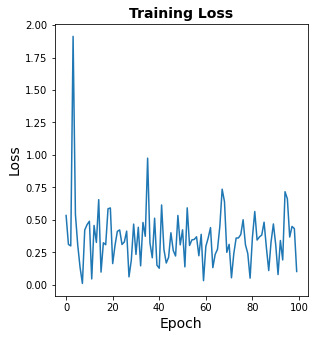

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)
hist = []
plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(5)
fig.set_figwidth(10)
plt.plot(np.array(loss_values))

**Prepare Detected faces data for working with VGGface2 pre-trained network**

In [ ]:
class CustomDataset2(Dataset):
    def __init__(self):
        self.imgs_path = r'detected_faces/detected_faces-1/'
        file_list = glob.glob(self.imgs_path + "*")
        print(file_list)
        self.data = []
        for class_path in file_list:
            class_name = class_path.split("\\")[-1]
            print("calss name: ", class_name)
            for img_path in glob.glob(class_path + "\*.png"):
                self.data.append([img_path, class_name])
        print(self.data)
        #self.class_map = {"Others" : 0, "Human_Face": 1 }
        self.class_map = { "Human_Face": 0 }
        self.img_dim = (128, 128)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        img = cv2.imread(img_path)
        img = cv2.resize(img, self.img_dim)
        class_id = self.class_map[class_name]
        img_tensor = torch.from_numpy(img)
        img_tensor = img_tensor.permute(2, 0, 1)
        class_id = torch.tensor([class_id])
        return img_tensor, class_id

In [ ]:
detected_data_dir = './detected_faces/'
new_dataset = CustomDataset2()
data_loader = DataLoader(new_dataset, batch_size=batch_size, shuffle=True)

['detected_faces/detected_faces-1\\Human_Face']
calss name:  Human_Face
[['detected_faces/detected_faces-1\\Human_Face\\detected_face_1.png', 'Human_Face'], ['detected_faces/detected_faces-1\\Human_Face\\detected_face_10.png', 'Human_Face'], ['detected_faces/detected_faces-1\\Human_Face\\detected_face_100.png', 'Human_Face'], ['detected_faces/detected_faces-1\\Human_Face\\detected_face_1000.png', 'Human_Face'], ['detected_faces/detected_faces-1\\Human_Face\\detected_face_1001.png', 'Human_Face'], ['detected_faces/detected_faces-1\\Human_Face\\detected_face_1002.png', 'Human_Face'], ['detected_faces/detected_faces-1\\Human_Face\\detected_face_1003.png', 'Human_Face'], ['detected_faces/detected_faces-1\\Human_Face\\detected_face_1004.png', 'Human_Face'], ['detected_faces/detected_faces-1\\Human_Face\\detected_face_1005.png', 'Human_Face'], ['detected_faces/detected_faces-1\\Human_Face\\detected_face_1006.png', 'Human_Face'], ['detected_faces/detected_faces-1\\Human_Face\\detected_face_10

**Testing**

In [ ]:
test_loader = DataLoader(new_dataset, batch_size=batch_size, shuffle=False)
new_labels = []
# Test the model
with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            labels = labels.to(device)
            labels = labels.float()
            outputs = model(images.float())
            #_, predicted = torch.max(outputs.data, 1)
            #print(outputs)
            for x in outputs:
                if(x >= 1):
                    new_labels.append(1)
                    #print('1')
                else:
                    new_labels.append(0)
                    #print('0')

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

print(new_labels)

        #print('Accuracy of the network on the test images: {} %'.format(100 * correct / total))

[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
#print(new_labels)
detected_data_dir = r'./detected_faces/detected_faces-1/Human_Face'

try:

	# creating a folder named data
	if not os.path.exists('validated_detected_face'):
		os.makedirs('validated_detected_face')

# if not created then raise error
except OSError:
	print ('Error: Creating directory of validated_detected_face')

currentImg = 0

src_dir = detected_data_dir
dst_dir = r'validated_detected_face/'
for filename in glob.iglob(os.path.join(src_dir, "*.png")):
    print(currentImg)
    if (new_labels[currentImg] == 0):
        shutil.copy(filename, dst_dir)
        print ('validating...' + filename)

    currentImg += 1

[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

validating..../detected_faces/detected_faces-1/Human_Face\detected_face_1077.png
83
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_1078.png
84
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_1079.png
85
86
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_1080.png
87
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_1081.png
88
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_1082.png
89
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_1083.png
90
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_1084.png
91
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_1085.png
92
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_1086.png
93
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_1087.png
94
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_1

validating..../detected_faces/detected_faces-1/Human_Face\detected_face_212.png
208
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_213.png
209
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_214.png
210
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_215.png
211
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_216.png
212
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_217.png
213
214
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_219.png
215
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_22.png
216
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_220.png
217
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_221.png
218
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_222.png
219
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_2

validating..../detected_faces/detected_faces-1/Human_Face\detected_face_36.png
357
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_360.png
358
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_361.png
359
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_362.png
360
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_363.png
361
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_364.png
362
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_366.png
363
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_367.png
364
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_368.png
365
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_37.png
366
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_371.png
367
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_372.pn

validating..../detected_faces/detected_faces-1/Human_Face\detected_face_46.png
457
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_460.png
458
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_461.png
459
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_464.png
460
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_465.png
461
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_466.png
462
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_467.png
463
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_468.png
464
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_469.png
465
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_47.png
466
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_470.png
467
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_471.pn

validating..../detected_faces/detected_faces-1/Human_Face\detected_face_632.png
640
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_633.png
641
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_634.png
642
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_635.png
643
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_636.png
644
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_637.png
645
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_638.png
646
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_639.png
647
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_64.png
648
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_640.png
649
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_641.png
650
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_642.p

validating..../detected_faces/detected_faces-1/Human_Face\detected_face_744.png
758
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_745.png
759
760
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_747.png
761
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_748.png
762
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_749.png
763
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_75.png
764
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_750.png
765
766
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_752.png
767
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_753.png
768
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_754.png
769
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_755.png
770
771
validating..../detected_faces/detected_faces-1/Human_Face\detecte

validating..../detected_faces/detected_faces-1/Human_Face\detected_face_902.png
925
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_903.png
926
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_904.png
927
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_905.png
928
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_906.png
929
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_907.png
930
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_908.png
931
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_909.png
932
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_91.png
933
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_910.png
934
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_911.png
935
validating..../detected_faces/detected_faces-1/Human_Face\detected_face_912.p